# Calcolo apnee da spO2

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import math
import numpy as np
from scipy.stats import linregress
import nolds
from lempel_ziv_complexity import lempel_ziv_complexity


Info: numba.jit seems to be available.


In [2]:
def zero_crossing(lista,media):
    zc=0
    for i in range (0,(len(lista)-1)):
        if(lista[i]<=media and lista[i+1]>media):
            zc+=1
        elif(lista[i]>=media and lista[i+1]<media):
            zc+=1
        elif(lista[i]<media and lista[i+1]>=media):
            zc+=1
        elif(lista[i]>media and lista[i+1]<=media):
            zc+=1
    return zc

In [3]:
def ApEn(U, m, r):

    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)

    return abs(_phi(m+1) - _phi(m))

# Usage example
U = np.array([85, 80, 89] * 17)

#print (ApEn(U, 2, 3))
#1.0996541105257052e-05

#randU = np.random.choice([85, 80, 89], size=17*3)
#print (ApEn(randU, 2, 3))

In [4]:
def tsa(lista, value):
    counter=0
    for i in range(0,len(lista)):
        if(lista[i]<value):
            counter+=1
    return counter

In [5]:
def ODIS(lista,value,baseline):
    counter=0
    for i in range (0, len(lista)):
        if(lista[i]<(baseline-value)):
            counter+=1
    return counter

In [13]:
def ODIXY(lista,x,y):
    counter=0
    durata=0
    for i in range(0,len(lista)):
        if(lista[0]<x):
            durata=1
        if(i>0 and lista[i]<x and lista[i-1]>=x):
            durata=1
        elif(i>0 and lista[i]<x and lista[i-1]<x):
            durata+=1
        if(i>0 and lista[i]>=x and lista[i-1]<x):
            if(durata>=y):
                counter+=1
            durata=0
    return counter

In [42]:
def odi(lista, value, baseline):
    counter=0
    soglia=baseline*(1-value/100)
    for i in range(0,len(lista)):
        if(lista[0]<=soglia):
            counter+=1
        elif(i>0 and lista[i-1]>soglia and lista[i]<=soglia):
            counter+=1
    return counter

In [6]:
mypath='C:/Users/sara/AppData/Local/VirtualStore/Program Files (x86)/SpO2 Assistant(ITD)V3.0.3/Data'    
df = pd.read_csv( mypath+'/prova6_20180725150233.csv', names=['date', 'time', 'spO2','pulse'],header=1)
spo2_array=df['spO2']

# Feature extraction



#### Divido in segmenti di 12 secondi per il calcolo di Dmean. Per ognuno calcolo la media e la differenza in valore assoluto con il segmento adiacente.

In [7]:
df12=pd.DataFrame(columns=['medie'])
numIntervalli12=len(spo2_array)/12
if(len(spo2_array)%12!=0):
    numIntervalli12+=1
numIntervalli12=math.floor(numIntervalli12)
intervalli12=[]
differenze=[]
medie12=[]
for i in range(0,numIntervalli12):
    intervalli12.append(spo2_array[i*12:i*12+12])
    medie12.append(statistics.mean(intervalli12[i]))
    if(i==0):
        differenze.append(0)
    if(i>0):
        differenze.append(abs(medie12[i]-medie12[i-1]))
df12['medie']=medie12
df12['differenze']=differenze
print(df12)

        medie  differenze
0   98.000000    0.000000
1   98.000000    0.000000
2   98.000000    0.000000
3   98.000000    0.000000
4   98.000000    0.000000
5   98.000000    0.000000
6   98.333333    0.333333
7   98.000000    0.333333
8   98.000000    0.000000
9   98.000000    0.000000
10  98.000000    0.000000
11  98.000000    0.000000
12  98.000000    0.000000
13  98.000000    0.000000
14  97.000000    1.000000
15  95.833333    1.166667
16  95.750000    0.083333
17  96.416667    0.666667
18  96.000000    0.416667
19  96.000000    0.000000
20  96.000000    0.000000
21  96.000000    0.000000
22  96.000000    0.000000
23  96.583333    0.583333
24  97.000000    0.416667
25  96.166667    0.833333
26  96.000000    0.166667
27  96.000000    0.000000
28  96.750000    0.750000
29  97.083333    0.333333
30  97.000000    0.083333
31  97.000000    0.000000
32  97.000000    0.000000
33  97.000000    0.000000
34  97.000000    0.000000
35  97.000000    0.000000
36  96.666667    0.333333
37  96.91666

#### Divido in segmenti di 1 minuto. Campionamento 1 Hz -> 1 minuto=60 misure. Calcolo le varie features

In [43]:
features=pd.DataFrame(columns=['medie'])
numIntervalli=len(spo2_array)/60
if(len(spo2_array)%60!=0):
    numIntervalli+=1
numIntervalli=math.floor(numIntervalli)
intervalli=[]
minimi=[]
medie=[]
varianze=[]
numZC=[]
slopes=[]
Dmean=[]
apEntr=[]
LZcomp=[]
tsa70=[]
tsa80=[]
tsa85=[]
tsa90=[]
tsa95=[]
baseline=[]
ODIS2=[]
ODIS3=[]
ODIS4=[]
ODIS5=[]

ODI21=[]
ODI31=[]
ODI41=[]
ODI51=[]
ODI23=[]
ODI33=[]
ODI43=[]
ODI53=[]
ODI25=[]
ODI35=[]
ODI45=[]
ODI55=[]

odi2=[]
odi3=[]
odi4=[]
for i in range(0,numIntervalli):
    intervalli.append(spo2_array[i*60:i*60+60])
    minimi.append(min(intervalli[i]))
    medie.append(statistics.mean(intervalli[i]))
    varianze.append(statistics.variance(intervalli[i]))
    intervallo_array=np.asarray(intervalli[i])
    numZC.append(zero_crossing(intervallo_array,medie[i]))
    x=np.arange(0,len(intervalli[i]),1)
    slope, intercept, r_value, p_value, std_err = linregress(x, intervalli[i])
    slopes.append(slope)
    Dmean.append(statistics.mean(differenze[i*5:i*5+5]))
  #  apEntr.append(nolds.sampen(intervalli[i]))
    apEntr.append(ApEn(intervallo_array,2,3))
    LZcomp.append(lempel_ziv_complexity(np.asarray(intervalli[i])))
    baseline.append(statistics.mean(sorted(intervalli[i],reverse=True)[:(math.floor(len(intervalli[i])*0.2))]))
    tsa70.append(tsa(intervallo_array,70))
    tsa80.append(tsa(intervallo_array,80))
    tsa85.append(tsa(intervallo_array,85))
    tsa90.append(tsa(intervallo_array,90))
    tsa95.append(tsa(intervallo_array,95))
    ODIS2.append(ODIS(intervallo_array,2,baseline[i]))
    ODIS3.append(ODIS(intervallo_array,3,baseline[i]))
    ODIS4.append(ODIS(intervallo_array,4,baseline[i]))
    ODIS5.append(ODIS(intervallo_array,5,baseline[i]))
    ODI21.append(ODIXY(intervallo_array,2,1))
    ODI31.append(ODIXY(intervallo_array,3,1))
    ODI41.append(ODIXY(intervallo_array,4,1))
    ODI51.append(ODIXY(intervallo_array,5,1))
    ODI23.append(ODIXY(intervallo_array,2,3))
    ODI33.append(ODIXY(intervallo_array,3,3))
    ODI43.append(ODIXY(intervallo_array,4,3))
    ODI53.append(ODIXY(intervallo_array,5,3))
    ODI25.append(ODIXY(intervallo_array,2,5))
    ODI35.append(ODIXY(intervallo_array,3,5))
    ODI45.append(ODIXY(intervallo_array,4,5))
    ODI55.append(ODIXY(intervallo_array,5,5))
    odi2.append(odi(intervallo_array,2,baseline[i]))
    odi3.append(odi(intervallo_array,4,baseline[i]))
    odi4.append(odi(intervallo_array,4,baseline[i]))
features['minimi']=minimi
features['medie']=medie
features['variance']=varianze
features['NumZC']=numZC
features['slope']=slopes
features['AbsSlope']=[abs(x) for x in slopes]
features['Dmean']=Dmean
features['apEntr']=apEntr
features['LZcomp']=LZcomp
features['tsa70']=tsa70
features['tsa80']=tsa70
features['tsa85']=tsa70
features['tsa90']=tsa70
features['tsa95']=tsa70
features['baseline']=baseline
features['ODIS2']=ODIS2
features['ODIS3']=ODIS3
features['ODIS4']=ODIS4
features['ODIS5']=ODIS5
features['ODI21']=ODI21
features['ODI31']=ODI31
features['ODI41']=ODI41
features['ODI51']=ODI51
features['ODI23']=ODI23
features['ODI33']=ODI33
features['ODI43']=ODI43
features['ODI53']=ODI53
features['ODI25']=ODI25
features['ODI35']=ODI35
features['ODI45']=ODI45
features['ODI55']=ODI55
features['odi2']=odi2
features['odi3']=odi3
features['odi4']=odi4
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(features)

       medie  minimi  variance  NumZC     slope  AbsSlope     Dmean  apEntr  \
0  98.000000      98  0.000000      0  0.000000  0.000000  0.000000     0.0   
1  98.066667      98  0.063277      2 -0.002445  0.002445  0.133333     0.0   
2  97.800000      96  0.298305      1 -0.017783  0.017783  0.200000     0.0   
3  96.000000      95  0.271186      4  0.004890  0.004890  0.466667     0.0   
4  96.316667      96  0.220056      1  0.021645  0.021645  0.200000     0.0   
5  96.400000      96  0.277966      2  0.021006  0.021006  0.416667     0.0   
6  97.000000      97  0.000000      0  0.000000  0.000000  0.016667     0.0   
7  96.683333      96  0.220056      3 -0.015810  0.015810  0.300000     0.0   
8  96.683333      96  0.220056      1  0.021645  0.021645  0.200000     0.0   
9  97.000000      97  0.000000      0  0.000000  0.000000  0.000000     0.0   

   LZcomp  tsa70  tsa80  tsa85  tsa90  tsa95   baseline  ODIS2  ODIS3  ODIS4  \
0       2      0      0      0      0      0  98.0

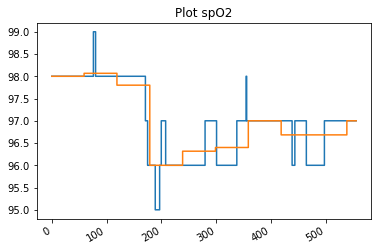

In [9]:
y=[]
#creo grafico medie
listemedie=[]
for i in range(0,len(intervalli)):
    for j in range(0,len(intervalli[i])):
        listemedie.append(medie[i])
for i in range (0,len(df)):
    y.append(i)
plt.figure(1)
plt.title('Plot spO2')
plt.gcf().autofmt_xdate()
plt.step(y,df['spO2'])
plt.step(y,listemedie)

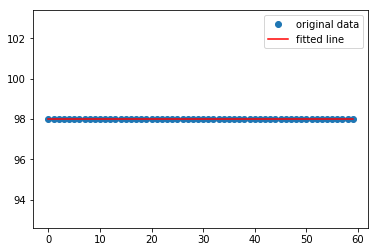

In [10]:
x=np.arange(0,len(intervalli[0]))
y=intervalli[0]
slope, intercept, r_value, p_value, std_err = linregress(x,intervalli[0])
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

In [11]:
# second order measure
y2=[]
x2=[]
for i in range(0,len(spo2_array)):
    if((i+2)<len(spo2_array)):
        y2.append(spo2_array[i+2]-spo2_array[i+1])
        x2.append(spo2_array[i+1]-spo2_array[i])


555

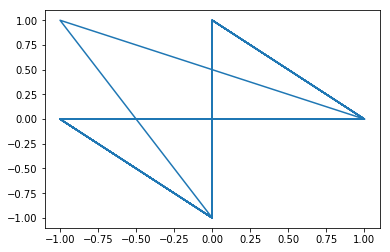

In [12]:
plt.figure(1)
plt.plot(y2,x2)
len(y2)
len(x2)


In [38]:
intervalli[3]

180    96
181    96
182    96
183    96
184    96
185    96
186    96
187    96
188    96
189    96
190    95
191    95
192    95
193    95
194    95
195    95
196    95
197    95
198    96
199    96
200    96
201    97
202    97
203    97
204    97
205    97
206    97
207    97
208    97
209    96
210    96
211    96
212    96
213    96
214    96
215    96
216    96
217    96
218    96
219    96
220    96
221    96
222    96
223    96
224    96
225    96
226    96
227    96
228    96
229    96
230    96
231    96
232    96
233    96
234    96
235    96
236    96
237    96
238    96
239    96
Name: spO2, dtype: int64

In [41]:
baseline[3]

96.66666666666667